In [1]:
# 사용할 패키지를 import합니다
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import glob
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic") # window
plt.rc("axes", unicode_minus=False) # x,y축 (-)부호 표시

import seaborn as sns

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pickle

# N stage info in clinical data

In [6]:
def get_class(x):
    if x!=x:
        return -1
    
    if x[:2] in ['N1','N2','N3']:
        return 1
    elif (x[:2]=='N0') and (x[-1]!=')'):
        return 0
    
    return -1

f1_list=glob.glob('D:/jmjung/n_stage_pred_BRCA/data/TCGA_clinical_2023/*_clinical.csv')

n_stage_dic={}
for f1 in f1_list:
    cln=pd.read_table(f1, sep=',')
    if 'ajcc_pathologic_n' not in cln.columns:
        continue
        
    cln=cln[['bcr_patient_barcode','ajcc_pathologic_n']]
    cln['class']=cln['ajcc_pathologic_n'].map(get_class)
    cln=cln.loc[cln['class']!=-1]
    
    n_cnt=cln['class'].value_counts()
    n_cnt
    if set(n_cnt.index)!=set([0,1]):
        continue
        
    if (n_cnt.loc[0]>=100) and (n_cnt.loc[1]>=100):
        can_code=f1.split('\\')[1].replace('TCGA-','').split('_')[0]
        n_stage_dic[can_code]=cln
        can_code

1    561
0    333
Name: class, dtype: int64

'BRCA'

# fpkm expression profiles

In [7]:
def quantile_normalize(df):
    """
    input: dataframe with numerical columns
    output: dataframe with quantile normalized values
    """
    
    df_sorted = pd.DataFrame(np.sort(df.values,axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return(df_qn)


In [9]:
for ii, can_code in enumerate(n_stage_dic.keys()):
    print(can_code)
    
    ## fpkm expression data load
    gene_exp=pd.read_table('D:/jmjung/n_stage_pred_BRCA/data/{0}/TCGA_{0}_GE_FPKM.txt'.format(can_code), index_col=0, sep='\t')
    
    ## mean expression by gene
    gene_exp=gene_exp.reset_index().groupby('gene_name').mean()
    
    ## mean expression by sample
    gene_exp.columns=['-'.join(col.split('-')[:3]) for col in gene_exp.columns]
    gene_exp=gene_exp.T.reset_index().groupby('index').mean()
        
    ## log2 transform
    gene_exp=gene_exp.applymap(lambda x: np.log2(x+1))
    
    ## quantile normalization per sample
    gene_exp=quantile_normalize(gene_exp.T).T
    
    ## merged data set: merge gene_expression to n_stage_info
    n_stage_info=n_stage_dic[can_code].set_index('bcr_patient_barcode')[['class']]

    merged_df=pd.merge(gene_exp, n_stage_info, how='inner', left_index=True, right_index=True)
        
#     with open('D:/jmjung/n_stage_pred_BRCA/mid_result/merged_data/{}.pickle'.format(can_code), 'wb') as f:
#         pickle.dump(merged_df, f)


BRCA


# Fig S1

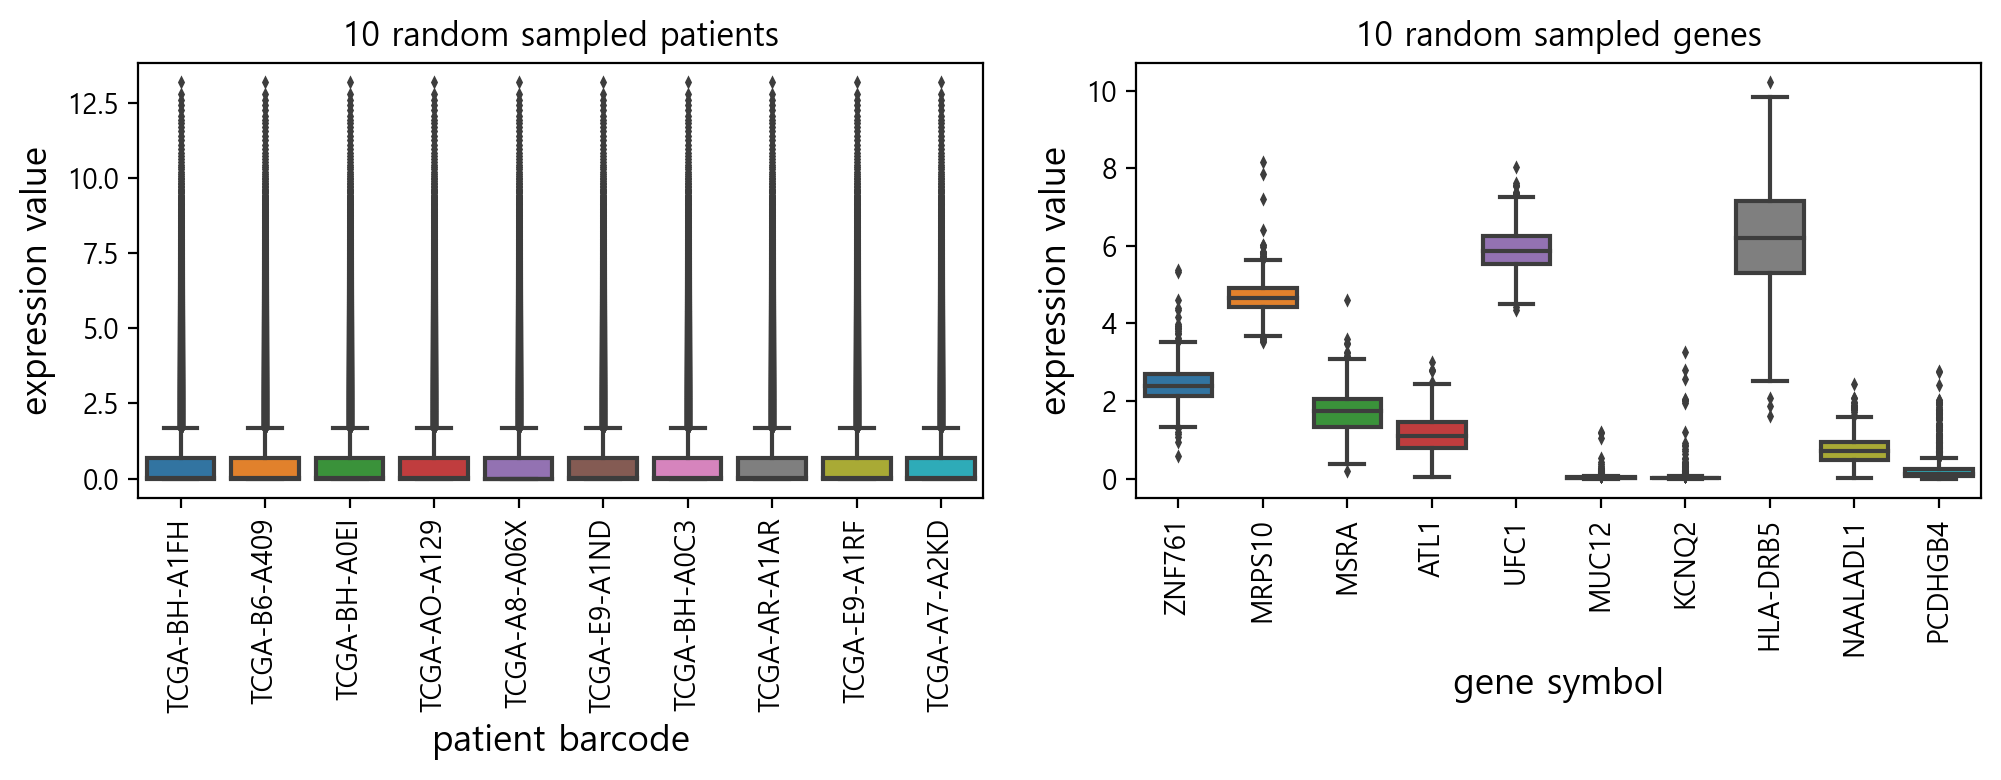

In [18]:
fig = plt.figure(figsize=(10,4), dpi=200)
axs=fig.subplots(1,2)

## plot distribution
# per sample
inds=np.random.choice(gene_exp.index, size=10, replace=False)
_=sns.boxplot(data=gene_exp.T[inds], ax=axs[0], fliersize=2)
_=axs[0].set_ylabel('expression value', fontsize=13)
_=axs[0].set_xlabel('patient barcode', fontsize=13)
_=axs[0].xaxis.label.set_size(13)
xticklabel=axs[0].get_xticklabels()
_=axs[0].set_xticklabels(xticklabel, rotation=90)
_=axs[0].set_title('10 random sampled patients')

# per gene
ccle_genes=list(pd.read_table('D:/jmjung/n_stage_pred_BRCA/data/ccle_gene_list.txt')['gene'])
cols=np.random.choice(ccle_genes, size=10, replace=False)
_=sns.boxplot(data=gene_exp[cols], ax=axs[1], fliersize=2)
_=axs[1].set_ylabel('expression value', fontsize=13)
_=axs[1].set_xlabel('gene symbol', fontsize=13)
_=axs[1].xaxis.label.set_size(13)
xticklabel=axs[1].get_xticklabels()
_=axs[1].set_xticklabels(xticklabel, rotation=90)
_=axs[1].set_title('10 random sampled genes')

fig.tight_layout(w_pad=2)
plt.savefig('D:/jmjung/n_stage_pred_BRCA/figs/fig_S1.jpg', dpi=200)